#  Entregable 3 - Aprendizaje Automático II


***<p style="text-align:center;">Implementación de una MLP con Backpropagation</p>***

En este cuaderno vamos a implementar una MLP (Multi-Layer Perceptron) con Backpropagation haciendo uso exclusivo de `numpy`.

### Normas de Entrega

1. El formato de entrega será en una carpeta comprimida con nombre: {Iniciales de Nombre y Apellidos}_E3.zip, en Aula Virtual en la fecha señalada en la plataforma y comunicada en clase previamente.
    * Por ejemplo: Iván Ramírez Díaz ==> `IRD_E3.zip`
2. El contenido de dicha carpeta será:
    * Obligatorio: Notebook relleno del Entregable 3.
    * Opcional: Memoria (pdf), en caso de necesitar dar alguna explicación.
3. Antes de la entrega, se debe comprobar que el código completo funciona.
4. La entrega es individual.

### Evaluación

La práctica entregable tiene un peso global de 1/4 puntos (los 4 entregables son el 10% de la nota final).

La práctica entregable se calificará sobre 10 puntos. Las puntuaciones son las siguientes:

- **[Ejercicio 1]** Implementa las clases: `Linear`, `Sigmoid` y `MSELoss`. (1.5 puntos) 
- **[Ejercicio 2]** Implementa la clase `SGD`y el modelo `MLP`. (1.5 puntos)
- **[Ejercicio 3]**  Entrena con los datos propuestos, una MLP en regresión. (2 puntos)
- **[Ejercicio 4]** Implementa la clase `L1Loss` y entrena el mismo modelo ahora con esta función de pérdidas. Compara los resultados. (1.5 puntos)
- **[Ejercicio 5]** Entrena el modelo anterior adaptándolo al `breast cancer dataset`que ya conoces usando `MSELoss` y `L1Loss`. De nuevo, compara los resultados. (1.5 puntos)
- **[Ejercicio 6]** Entrena el modelo anterior adaptándolo al `breast cancer dataset`que ya conoces implementando previamente una función de pérdida de clasificación, por ejemplo, la *binary cross entropy*  `BXELoss`. (2 puntos)


## **[Ejercicio 1]**

Implementa las clases: `Linear`, `Sigmoid` y `MSELoss`.

### Definición de clase base

Como hemos visto en clase, todas y cada una de las funciones en un framework de diferenciación automática implementan tanto la función en sí como sus derivadas. De esta manera, se habilita el uso del algoritmo de retropropagación.

Toda clase que implemente una función en una red neuronal, tendrá dos métodos fundamentales:
* forward: consiste en la evaluación de dicha función $f(x)$ para una entrada $x$ dada.
* backward: consiste en la retropropagación de las derivadas/jacobianos desde la salida hasta los parámetros

De forma genérica, vamos a definir unos atributos y métodos mínimos para cada función *diferenciable*:
* Si la función no es paramétrica (función de activación, por ejemplo):

    * `init`: la clase tendrá `self.p = None` (no tiene parámetros)
    * `foward`:
      1. El método recibirá: $x$, que será la salida de la función anterior.
      2. El método tendrá: `self.f`, que será la evaluación de la función $f(x)$.
      3. El método devolverá: `self.f`.
    * `backward`:
        1. El método recibirá: `dL_df`, que será la derivada de la pérdida hasta la salida de la función $f$.
        2. El método tendrá: `self.df_dx`, que será la derivada de la función $f$ con respecto a la entrada $x$.
        3. El método devolverá: `dL_dx`, que será la aplicación de la regla de la cadena $\frac{\partial L}{\partial x} = \frac{\partial f}{\partial x} \frac{\partial L}{\partial f}$

* Si, además, la función depende de una serie de parámetros:

    * `init`:
      1. La clase definirá en `self.p` una lista de parámetros a utilizar.
      2. La clase tendrá `self.dL_dp` que será una lista de las posibles evaluaciones de los gradientes de los parámetros.
    * `backward`:
      1. Se calculará además `df_dp`, es decir, las derivadas de $f$ con respecto a cada uno de los parámetros $\frac{\partial f}{\partial p_i}$.
      2. La clase calculará `dL_dp` aplicando la regla de la cadena y añadirá la evaluación a la lista `self.dL_dp`.

### Capa Linear (afín):

Siguiendo las indicaciones anteriores, consideramos una capa lineal definida tal que:

$$
f(x) = {\bf{W}} {\bf{x}} + {\bf{b}}
$$

donde ${\bf{W}} \in \mathbb{R}^{m,n}, {\bf{x}} \in \mathbb{R}^{n}, {\bf{b}} \in \mathbb{R}^{m}, f \in \mathbb{R}^{m}$.

Las matrices jacobianas de interés son:

$$
\frac{\partial f}{\partial {\bf{x}}} = {\bf{W}}^T
$$

$$
\frac{\partial f}{\partial {\bf{b}}} = {\bf{I}}
$$

$$
\frac{\partial f}{\partial {\bf{W}}} = \begin{bmatrix}{\bf{x}} & \cdots & 0 \\
                                                        \vdots & \ddots & 0 \\
                                                        0 & 0 &{\bf{x}} \end{bmatrix} \in \mathbb{R}^{m\cdot n, m}
$$

Sobre esta última matriz jacobiana, conviene hacer un comentario de implementación. En la formulación propuesta arriba, se asume ${\bf{W}}$ como un vector $\mathbb{R}^{m\cdot n}$, aunque en realidad es una matriz de tamaño $m \times n$. De esta manera, generalizan las derivadas y se pueden ir aplicando los jacobianos siempre de la misma manera, es decir, multiplicando por la izquierda a los gradientes previos. Esto es, de forma genérica: $\frac{\partial L}{\partial x} = \frac{\partial f}{\partial x} \frac{\partial L}{\partial f}$.

Sin embargo, esta matriz tiene muchos elementos a 0, lo cual no es eficiente en términos de memoria y operaciones a realizar en la multiplicación matricial. Una alternativa habitual (con abuso de notación) es definir esta derivada (no el Jacobiano) como:

$$
\frac{\partial f}{\partial {\bf{W}}} = x^T
$$

y, en vez de multiplicar por la izquierda, hacerlo por la derecha. Es decir, de forma genérica: $\frac{\partial L}{\partial x} =  \frac{\partial L}{\partial f} \frac{\partial f}{\partial x}$. 

La ventaja es doble: 1) eliminamos las componentes a 0 y las operaciones innecesarias y 2) el resultado es una matriz que coincide en dimensiones con las de ${\bf{W}}$, lo cual es muy conveniente para la actualización de parámetros.

In [337]:
import random

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [338]:
class Linear:
    def __init__(self, input_dim, output_dim, std=1):
        # Inicializamos pesos aleatorios y sesgo
        self.W = std*np.random.randn(input_dim, output_dim)
        self.b = std*np.random.randn(1, output_dim)

        ########################### COMPLETAR ###########################
        self.p = [self.W, self.b]
        self.dL_dp = []
        ######################### FIN COMPLETAR #########################
    def __call__(self, x):
        return self.forward(x)

    def forward(self, x):
        ########################### COMPLETAR ###########################
        self.x = x
        return x @ self.W + self.b
        ######################### FIN COMPLETAR #########################

    def backward(self, dL_df):
        ########################### COMPLETAR ###########################
        N = dL_df.shape[0]
        # Derivadas con respecto a la entrada x
        dL_dx = dL_df @ self.W.T
        self.dL_dx = dL_dx

        # Derivadas con respecto a los parámetros

        # Con respecto a W
        self.dL_dW = self.x.T @ dL_df

        # Con respecto a b
        self.dL_db = np.sum(dL_df, axis = 0, keepdims=True)

        # Se añaden a la lista de gradientes
        self.dL_dp = [self.dL_dW, self.dL_db]

        return dL_dx
        ######################### FIN COMPLETAR #########################


### Capa de Activación (sigmoide):

Siguiendo las indicaciones anteriores, consideramos una capa de activación definida por una sigmoide:

$$
f(x) = \sigma({\bf{x}}) = \frac{1}{1 + e^{-{\bf{x}}}}
$$

donde ${\bf{x}} \in \mathbb{R}^{n}, f \in \mathbb{R}^{n}$.

La derivada con respecto a la entrada es:

$$
\frac{d f}{d {\bf{x}}} = \sigma({\bf{x}}) \cdot (1 - \sigma({\bf{x}})) = \begin{bmatrix}\sigma({\bf{x}_1}) \cdot (1 - \sigma({\bf{x}_1}))\\
                                                        \vdots  \\
                                                        \sigma({\bf{x}_n}) \cdot (1 - \sigma({\bf{x}_n})) \end{bmatrix} \in \mathbb{R}^{n}
$$
La matriz jacobiana:

$$
\frac{\partial f}{\partial {\bf{x}}} = diag(\sigma({\bf{x}}) \cdot (1 - \sigma({\bf{x}}))) = \begin{bmatrix}\sigma({\bf{x}_1}) \cdot (1 - \sigma({\bf{x}_1})) & \cdots & 0 \\
                                                        \vdots & \ddots & 0 \\
                                                        0 & 0 &\sigma({\bf{x}_n}) \cdot (1 - \sigma({\bf{x}_n})) \end{bmatrix} \in \mathbb{R}^{ n,n}
$$

Similar a lo que ocurría antes con el parámetro ${\bf{W}}$, la matriz Jacobiana de la activación es diagonal, teniendo de nuevo gran cantidad de ceros e incrementando la complejidad del número de operaciones. Por ello, se suele utilizar la derivada $\frac{d f}{d {\bf{x}}}$ aplicada como producto de Hadamard, es decir, punto a punto:  $\frac{\partial L}{\partial x} = \frac{d f}{d {\bf{x}}} \odot \frac{\partial L}{\partial f}$


In [339]:
class Sigmoid:
    def __init__(self):
        ########################### COMPLETAR ###########################
        self.p = None
        ######################### FIN COMPLETAR #########################

    def __call__(self, x):
        return self.forward(x)
        
    def forward(self, x):
        ########################### COMPLETAR ###########################
        x = np.clip(x, -500, 500) #para evitar overflows
        self.f = 1 / (1 + np.exp(-x))
        return self.f
        ######################### FIN COMPLETAR #########################

    def backward(self, dL_df):
        ########################### COMPLETAR ###########################
        df_dx = self.f * (1 - self.f)

        # Derivada con respecto a la entrada
        dL_dx = dL_df * df_dx

        return dL_dx
        ######################### FIN COMPLETAR #########################


### Función de Pérdida (MSE):

De forma similar, implementamos la función de pérdida MSE, con una diferencia.

Las funciones de pérdida, suelen corresponder al último nodo del grafo de operaciones, por lo que debe iniciar la cadena de retropropagación al "llamar" al método `backward` para un modelo dado como argumento.

In [340]:
class MSELoss:
    def __init__(self):
        ########################### COMPLETAR ###########################
        self.p = None
        ######################### FIN COMPLETAR #########################

    def __call__(self, y_pred, y_true):
        return self.forward(y_pred, y_true)
        
    def forward(self, y_pred, y_true):
        ########################### COMPLETAR ###########################
        self.y_pred = y_pred
        self.y_true = y_true
        self.f = np.square(y_pred - y_true)
        return np.mean(self.f)
        ######################### FIN COMPLETAR #########################

    def backward(self, model=None):
        ########################### COMPLETAR ###########################
        N = self.y_pred.shape[0]
        self.df_dx = 2 * (self.y_pred - self.y_true) / N
        
        if model is not None:
            model.backward(self.df_dx)
        ######################### FIN COMPLETAR #########################


## **[Ejercicio 2]**

Implementa la clase: `SGD`y el modelo `MLP`

### Modelo de perceptrón multi-capa (MLP):

En esta clase, se instancian en el `init`, las distintas capas a utilizar en el modelo, así como sus parámetros (dimensiones de entrada y salida).

Además, del `forward`y `backward`, es conveniente añadir un método para resetear (poner a cero o null) los gradientes. Para ello, se añade `zero_grads`.

In [341]:
class MLP:
    def __init__(self, input_dim, output_dim):
        ########################### COMPLETAR ###########################
        F1 = Linear(input_dim, 128)# Capa lineal con 128 neuronas de salida
        Act1 = Sigmoid() # Capa de activación
        F2 = Linear(128, output_dim) # Capa de salida
        Act2 = Sigmoid()
        self.layers = [F1, Act1, F2, Act2]
        ######################### FIN COMPLETAR #########################

    def __call__(self, x):
        return self.forward(x)


    def forward(self, x):
        ########################### COMPLETAR ###########################
        # Forward de la red
        for l in self.layers:
            x = l.forward(x)
        return x
        ######################### FIN COMPLETAR #########################

    def backward(self, dL_df):
        ########################### COMPLETAR ###########################
        # Backward de la red
        for l in reversed(self.layers):
            dL_df = l.backward(dL_df)
        ######################### FIN COMPLETAR #########################

    def zero_grads(self):
        ########################### COMPLETAR ###########################
        # Para cada capa, resetea los gradientes
        for l in self.layers:
            l.dL_dp = []
        ######################### FIN COMPLETAR #########################


### Stocastic-Gradient Descent (Optimizador)

Implementamos un optimizador (SGD) para actualizar los valores de los parámetros.

Este optimizador, tendrá, al menos, un método llamado `step`.

In [342]:
class SGD:
    def __init__(self, lr):
        self.lr = lr

    def step(self, model):
        for layer in model.layers:
            # Solo capas con parámetros
            if hasattr(layer, "p") and layer.p is not None and hasattr(layer, "dL_dp") and layer.dL_dp:

                # layer.p = [W, b]
                # layer.dL_dp = [dW, db]
                for param, grad in zip(layer.p, layer.dL_dp):
                    param -= self.lr * grad

                # reset gradientes de la capa
                layer.dL_dp = []


## **[Ejercicio 3]**

Entrena con los datos propuestos, una MLP en regresión.

Generamos unos datos a partir de la superficie siguiente:

In [343]:
import numpy as np
import plotly.graph_objects as go

# Crear un grid uniforme en el espacio de entrada
grid_size = 50  # Tamaño del grid para un muestreo más denso
x1 = np.linspace(0, 1, grid_size)
x2 = np.linspace(0, 1, grid_size)
X1, X2 = np.meshgrid(x1, x2)

# Calcular y_true para cada punto en el grid sin ruido
Y_org = np.sin(2 * np.pi * X1) + np.cos(2 * np.pi * X2)

# Crear la gráfica de superficie
fig = go.Figure(data=[go.Surface(
    x=X1, 
    y=X2, 
    z=Y_org,
    colorscale='Inferno'
)])

# Configuración del layout
fig.update_layout(
    scene=dict(
        xaxis_title='X1', 
        yaxis_title='X2', 
        aspectmode='cube',  # Asegura escalado igual en todos los ejes
        xaxis=dict(backgroundcolor='rgb(230, 230, 230)', gridcolor='white', showbackground=True),  # Fondo gris claro
        yaxis=dict(backgroundcolor='rgb(230, 230, 230)', gridcolor='white', showbackground=True),  # Fondo gris claro
        zaxis=dict(backgroundcolor='rgb(230, 230, 230)', gridcolor='white', showbackground=True)   # Fondo gris claro
    ),
    width=800,  # Aumenta el tamaño de la figura
    height=800,  # Aumenta el tamaño de la figura
    margin=dict(l=0, r=0, b=0, t=50),  # Reduce los márgenes
    title="Superficie de la función original de la que se obtienen muestras ruidosas",  # Añade el título
    title_font=dict(size=20, family='Arial, sans-serif'),  # Personaliza la fuente del título
    scene_camera=dict(eye=dict(x=1.5, y=1.5, z=1.5)),  # Ángulo de cámara predeterminado para mejor visualización
)

# Mostrar la gráfica
fig.show()


Dado el modelo anterior, generamos unas muestras de entrenamiento ruidosas:

In [344]:
np.random.seed(1)

# Parámetros de entrada y salida
input_dim = 2   # Dimensiones de entrada
output_dim = 1  # Dimensiones de salida

# Generación de datos de ejemplo
n_samples = 250
X_train = np.random.rand(n_samples, input_dim)  # Entradas aleatorias
y_train = np.sin(2 * np.pi * X_train[:,0:1]) + np.cos(2 * np.pi * X_train[:,1:]) + 0.1 * np.random.randn(n_samples, output_dim)  # Salidas deseadas

Entrena, con el `batch_size` que consideres, la `MLP` que has creado anteriormente.

In [345]:
epochs = 100

########################### COMPLETAR ###########################
# Instancia el modelo, la función de pérdida y el optimizador
lr = 0.1
batch_size = 20

model = MLP(input_dim, output_dim)
loss_fn = MSELoss()
opt = SGD(lr = lr)
######################### FIN COMPLETAR #########################

losses = []

for e in tqdm(range(epochs)): # Para cada época
    loss = []
    permutation = np.random.permutation(X_train.shape[0])
    X_shuffled = X_train[permutation]
    Y_shuffled = y_train[permutation]
    for b in range(n_samples//batch_size): # Para cada batch
        # Obten el batch para el SGD
        start_idx = b * batch_size
        end_idx = (b+1) * batch_size
        ########################### COMPLETAR ##########################
        x_train_batch = X_shuffled[start_idx:end_idx]
        y_train_batch = Y_shuffled[start_idx:end_idx]
        ######################### FIN COMPLETAR #########################


        ########################### COMPLETAR ###########################
        # Forward
        x_batch_col = x_train_batch.T
        y_pred =  model(x_train_batch)
        loss_value = loss_fn(y_pred, y_train_batch)
        # Backward
        loss_fn.backward(model = model)
        ######################### FIN COMPLETAR #########################

        loss.append(loss_value)

        ########################### COMPLETAR ###########################
        # Descenso de gradiente (optimizador)
        opt.step(model)
        # Reset de los gradientes calculados
        model.zero_grads()
        ######################### FIN COMPLETAR #########################
    losses.append(np.mean(loss))



100%|██████████| 100/100 [00:00<00:00, 1041.64it/s]


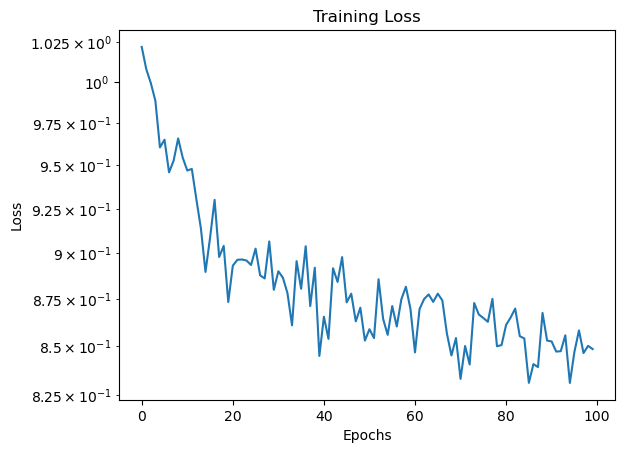

In [346]:
# Visualizar la pérdida
plt.figure()
plt.plot(np.asarray(losses))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Training Loss')
plt.show()

In [347]:
import plotly.graph_objs as go

# Lista de predicciones
predictions = []

# Prediciones de entrenamiento
for i in range(len(X_train)):
    y_pred = model(X_train[i].reshape(1, -1)).flatten()[0]  # Ensure single value output
    predictions.append(y_pred)

# Plots
fig = go.Figure()

# Plot predicciones
fig.add_trace(go.Scatter3d(
    x=X_train[:, 0],  
    y=X_train[:, 1],  
    z=predictions, 
    mode='markers',
    marker=dict(color='red', size=8, symbol='circle', opacity=0.8),
    name='y_pred',  
))

# Plot y_train
fig.add_trace(go.Scatter3d(
    x=X_train[:, 0],  
    y=X_train[:, 1],  
    z=y_train.flatten(), 
    mode='markers',
    marker=dict(color='blue', size=8, symbol='circle', opacity=0.8),  
    name='y_true',  
))

# Ajuste del layout
fig.update_layout(
    scene=dict(
        xaxis_title='X1', 
        yaxis_title='X2', 
        aspectmode='cube',  # Ensures equal scaling of all axes
        xaxis=dict(backgroundcolor='rgb(230, 230, 230)', gridcolor='white', showbackground=True),  # Light gray background
        yaxis=dict(backgroundcolor='rgb(230, 230, 230)', gridcolor='white', showbackground=True),  # Light gray background
        zaxis=dict(backgroundcolor='rgb(230, 230, 230)', gridcolor='white', showbackground=True)   # Light gray background
    ),
    width=800,  # Increase the size of the figure
    height=800,  # Increase the size of the figure
    margin=dict(l=0, r=0, b=0, t=0),  # Reduce margins
    title="Predición de la MLP",  # Add title
    title_font=dict(size=20, family='Arial, sans-serif'),  # Customize title font
    scene_camera=dict(eye=dict(x=1.5, y=1.5, z=1.5)),  # Set the default camera angle for better visualization
)

fig.show()

mae = np.mean(np.abs(y_pred_train - y_train.flatten()))
print("MAE:", mae)

MAE: 0.7667938535641423


Parece que con las activaciones, el ruido, número de éopcas y el optimizador propuesto el resultado no es muy bueno puesto que obtenemos un valor para MAE bastante alto.

## **[Ejercicio 4]**

Implementa la clase `L1Loss` y entrena el mismo modelo ahora con esta función de pérdidas. Compara los resultados. 


In [348]:
class L1Loss:
    def __init__(self):
        ########################### COMPLETAR ###########################
        self.p = None
        ######################### FIN COMPLETAR #########################

    def __call__(self, y_pred, y_true):
        return self.forward(y_pred, y_true)
        
    def forward(self, y_pred, y_true):
        ########################### COMPLETAR ###########################
        self.y_pred = y_pred
        self.y_true = y_true
        self.f =    np.mean(np.abs(y_pred - y_true))
        return self.f
        ######################### FIN COMPLETAR #########################

    def backward(self, model=None):
        ########################### COMPLETAR ###########################
        N = self.y_pred.shape[0]
        self.df_dx = np.sign(self.y_pred - self.y_true)
        
        if model is not None:
            model.backward(self.df_dx)
        ######################### FIN COMPLETAR #########################

In [349]:
epochs = 100

########################### COMPLETAR ###########################
# Instancia el modelo, la función de pérdida y el optimizador
lr = 0.01
batch_size = 32

model = MLP(input_dim, output_dim)
loss_fn = L1Loss()
opt = SGD(lr = lr)
######################### FIN COMPLETAR #########################

losses_l1 = []

for e in tqdm(range(epochs)): # Para cada época
    loss = []
    permutation = np.random.permutation(X_train.shape[0])
    X_shuffled = X_train[permutation]
    Y_shuffled = y_train[permutation]

    for b in range(n_samples // batch_size): # Para cada batch

        # Obten el batch para el SGD
        ########################### COMPLETAR ###########################
        start_idx = b * batch_size
        end_idx   = (b + 1) * batch_size
        x_train_batch = X_shuffled[start_idx:end_idx]
        y_train_batch = Y_shuffled[start_idx:end_idx]
        ######################### FIN COMPLETAR #########################

        ########################### COMPLETAR ###########################
        # Forward
        y_pred = model(x_train_batch)
        loss_value = loss_fn(y_pred, y_train_batch)

        # Backward
        loss_fn.backward(model)
        ######################### FIN COMPLETAR ###########################

        loss.append(loss_value)

        ########################### COMPLETAR ###########################
        # Descenso de gradiente (optimizador)
        opt.step(model)

        # Reset de los gradientes calculados
        model.zero_grads()
        ######################### FIN COMPLETAR ###########################

    # GUARDAMOS UN VALOR DE PÉRDIDA POR ÉPOCA
    losses_l1.append(np.mean(loss))


100%|██████████| 100/100 [00:00<00:00, 1428.59it/s]


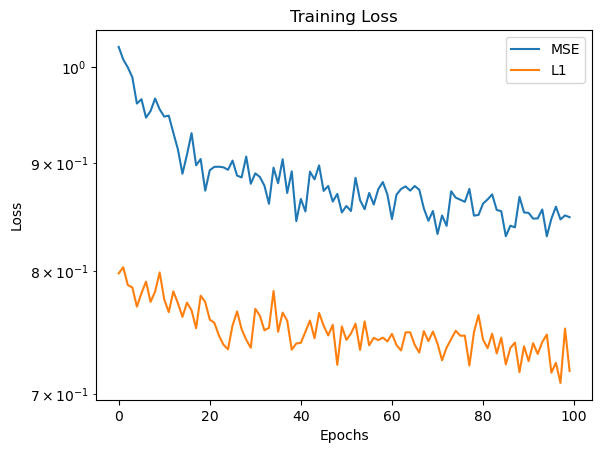

In [350]:
# Visualizar la pérdida
plt.figure()
plt.plot(np.asarray(losses))
plt.plot(np.asarray(losses_l1))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Training Loss')
plt.legend(['MSE', 'L1'])
plt.show()

In [351]:
import plotly.graph_objs as go

# Lista de predicciones
predictions = []

# Prediciones de entrenamiento
for i in range(len(X_train)):
    y_pred = model(X_train[i].reshape(1, -1)).flatten()[0]  # Ensure single value output
    predictions.append(y_pred)

# Plots
fig = go.Figure()

# Plot predicciones
fig.add_trace(go.Scatter3d(
    x=X_train[:, 0],  
    y=X_train[:, 1],  
    z=predictions, 
    mode='markers',
    marker=dict(color='red', size=8, symbol='circle', opacity=0.8),
    name='y_pred',  
))

# Plot y_train
fig.add_trace(go.Scatter3d(
    x=X_train[:, 0],  
    y=X_train[:, 1],  
    z=y_train.flatten(), 
    mode='markers',
    marker=dict(color='blue', size=8, symbol='circle', opacity=0.8),  
    name='y_true',  
))

# Ajuste del layout
fig.update_layout(
    scene=dict(
        xaxis_title='X1', 
        yaxis_title='X2', 
        aspectmode='cube',  # Ensures equal scaling of all axes
        xaxis=dict(backgroundcolor='rgb(230, 230, 230)', gridcolor='white', showbackground=True),  # Light gray background
        yaxis=dict(backgroundcolor='rgb(230, 230, 230)', gridcolor='white', showbackground=True),  # Light gray background
        zaxis=dict(backgroundcolor='rgb(230, 230, 230)', gridcolor='white', showbackground=True)   # Light gray background
    ),
    width=800,  # Increase the size of the figure
    height=800,  # Increase the size of the figure
    margin=dict(l=0, r=0, b=0, t=0),  # Reduce margins
    title="Predición de la MLP",  # Add title
    title_font=dict(size=20, family='Arial, sans-serif'),  # Customize title font
    scene_camera=dict(eye=dict(x=1.5, y=1.5, z=1.5)),  # Set the default camera angle for better visualization
)

fig.show()
mae = np.mean(np.abs(y_pred_train - y_train.flatten()))
print("MAE:", mae)


MAE: 0.7667938535641423


Parece que con las activaciones, el ruido, número de éopcas y el optimizador propuesto el resultado no es muy bueno puesto que obtenemos un valor para MAE bastante alto.

## **[Ejercicio 5]** 

Entrena el modelo anterior adaptándolo al `breast cancer dataset`que ya conoces usando `MSELoss` y `L1Loss`. De nuevo, compara los resultados. 

(455, 30)
(455, 1)
(114, 30)
(114, 1)


100%|██████████| 500/500 [00:00<00:00, 551.63it/s]


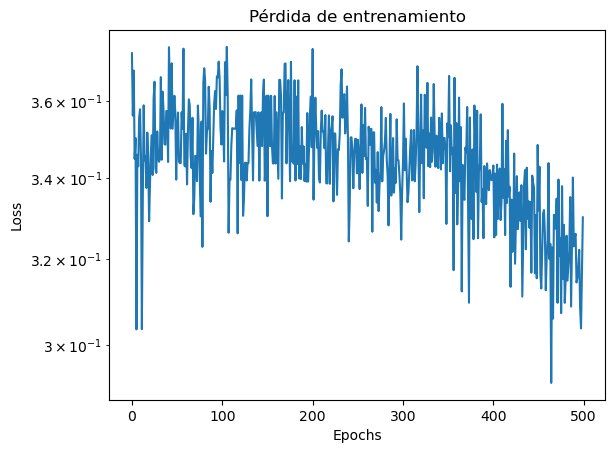

In [352]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

########################### COMPLETAR ###########################
# Cargar el dataset
data = load_breast_cancer()
X = data.data
y = data.target.reshape(-1, 1) #forma tipo (N, 1)


# Dividir el dataset en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test =  train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

######################### FIN COMPLETAR #########################

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


# Añade un método `predict` para contemplar la predicción de varios ejemplos

class MLP:
    def __init__(self, input_dim, output_dim, std=1):
        ########################### COMPLETAR ###########################
        F1 =  Linear(input_dim, 128, std = std) # Capa lineal con 128 neuronas de salida
        Act1 = Sigmoid() # Capa de activación
        F2 =  Linear(128, output_dim, std = std)# Capa de salida
        Act2 = Sigmoid()
        self.layers = [F1, Act1, F2, Act2]
        ######################### FIN COMPLETAR #########################

    def __call__(self, x):
        return self.forward(x)

    def forward(self, x):
        ########################### COMPLETAR ###########################
        # Forward de la red
        out = x
        for layer in self.layers:
            out = layer(out)

        return out
        ######################### FIN COMPLETAR #########################

    def backward(self, dL_df):
        ########################### COMPLETAR ###########################
        # Backward de la red
        grad = dL_df
        for layer in reversed(self.layers):
            grad = layer.backward(grad)
        ######################### FIN COMPLETAR #########################

    def zero_grads(self):
        ########################### COMPLETAR ###########################
        # Para cada capa, resetea los gradientes
        for layer in self.layers:
            if hasattr(layer, "dL_dp"):
                layer.dL_dp = [np.zeros_like(layer.W), np.zeros_like(layer.b)]

        ######################### FIN COMPLETAR #########################

    def predict(self, x):
        ########################### COMPLETAR ###########################
        # Para cada ejemplo del batch
        # Asegurar que x es 2D
        if x.ndim == 1:
            x = x.reshape(1, -1)
        return self.forward(x)
        ######################### FIN COMPLETAR #########################


epochs = 500

########################### COMPLETAR ###########################
# Instancia el modelo, la función de pérdida y el optimizador
lr = 0.01
batch_size = 32

model = MLP(input_dim=X_train.shape[1], output_dim=1)
loss_fn = L1Loss()
opt = SGD(lr=lr)
######################### FIN COMPLETAR #########################
losses = []

for e in tqdm(range(epochs)):
    loss = []
    idx = np.random.permutation(n_samples)
    X_train = X_train[idx]
    y_train = y_train[idx]
    for b in range(n_samples//batch_size):

        ########################### COMPLETAR ###########################
        #minibatch
        start = b * batch_size
        end = start + batch_size
        X_batch = X_train[start:end]
        y_batch = y_train[start:end]

        #fordward
        y_pred = model(X_batch)

        #loss
        loss_value = loss_fn(y_pred, y_batch)

        #backward
        loss_fn.backward(model)

        #update
        opt.step(model)

        #reset gradient
        model.zero_grads()

        loss.append(loss_value)

    losses.append(np.mean(loss))

        ######################### FIN COMPLETAR #########################

# Visualizar la pérdida
plt.plot(np.asarray(losses))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Pérdida de entrenamiento')
plt.show()


## **[Ejercicio 6]**

Entrena el modelo anterior adaptándolo al `breast cancer dataset`que ya conoces implementando previamente una función de pérdida de clasificación, por ejemplo, la *binary cross entropy*  `BXELoss`.

- Implementamos `BXELoss`:

In [353]:
class BCELoss:
    def __init__(self):
        self.p = None #no tiene parámetros

    def __call__(self, y_pred, y_true):
        return self.fordward(y_pred, y_true)

    def fordward(self, y_pred, y_true):
        eps = 1e-12 #para evitar problemas numericos
        y_pred = np.clip(y_pred, eps, 1 - eps)

        self.y_pred = y_pred
        self.y_true = y_true

        #binary cross entropy
        self.f = -np.mean(
            y_true * np.log(y_pred) +
            (1 - y_true) * np.log(1 - y_pred)
        )
        return self.f

    def backward(self, model = None):
        eps = 1e-12 #para evitar problemas numericos
        y_pred = np.clip(self.y_pred, eps, 1 - eps)
        N = self.y_pred.shape[0]

        #derivada dL/dy
        self.df_dx = (y_pred - self.y_true) / (y_pred * (1 - y_pred) * N)

        if model is not None:
            model.backward(self.df_dx)

- Entrenamos:

In [354]:
epochs = 100
lr = 0.01
batch_size = 32

#modelo de clasificación binaria
model = MLP(input_dim = X_train.shape[1], output_dim = 1)

#perdida BCE
loss_fn = BCELoss()

opt = SGD(lr = lr)

n_samples = X_train.shape[0]
losses = []


for e in tqdm(range(epochs)):
    loss = []

    idx = np.random.permutation(n_samples)
    X_train = X_train[idx]
    y_train = y_train[idx]

    for b in range(n_samples // batch_size):
        start = b * batch_size
        end = start + batch_size
        X_batch = X_train[start:end]
        y_batch = y_train[start:end]

        #fordward
        y_pred = model(X_batch)

        #loss
        loss_value = loss_fn(y_pred, y_batch)

        #backprop
        loss_fn.backward(model)

        #update
        opt.step(model)

        #limipar gradientes
        model.zero_grads()

        loss.append(loss_value)

    losses.append(np.mean(loss))


100%|██████████| 100/100 [00:00<00:00, 552.22it/s]


In [355]:
y_pred_test = model.predict(X_test)
y_pred_class = (y_pred_test > 0.5).astype(int)

accuracy = np.mean(y_pred_class == y_test)
print(f"Precisión test: {accuracy * 100:.2f}%")


Precisión test: 89.47%
